<a href="https://colab.research.google.com/github/SonamKul9527/Melanoma_Detection_Assignment/blob/main/sonam_k_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

We will build a multiclass classification model using a custom convolutional neural network in TensorFlow

In [1]:
## Mount Google Drive to load the data from Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
## Unzipping the data from specified drive folder

!unzip -q "/content/gdrive/My Drive/CNN_assignment.zip" -d "/content/gdrive/My Drive/CNN_assignment"

replace /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
## Importing Required Libraries

import os
import PIL
import pathlib 

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import load_img

import matplotlib.pyplot as plt
import numpy as np, pandas as pd

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
## Defining the path for Train and Test images directories

data_dir_train = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
## Count the number of images in Train and Test Directories. Using the glob to retrieve files/pathnames matching a specified pattern.

## Train Image Count
img_train_cnt = len(list(data_dir_train.glob('*/*.jpg')))
print(img_train_cnt)

## Test Image Count
img_test_cnt = len(list(data_dir_test.glob('*/*.jpg')))
print(img_test_cnt)

2238
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size = batch_size, seed = 123, image_size = (img_height, img_width),
    validation_split=0.2, subset='training',  label_mode='categorical'
    )

Found 2238 files belonging to 9 classes.
Using 1791 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size = batch_size, seed = 123, image_size = (img_height, img_width),
    validation_split=0.2, subset='validation', label_mode='categorical'
)

Found 2238 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Data Visualization

Creating a code to visualize one instance of all the nine classes present in the dataset

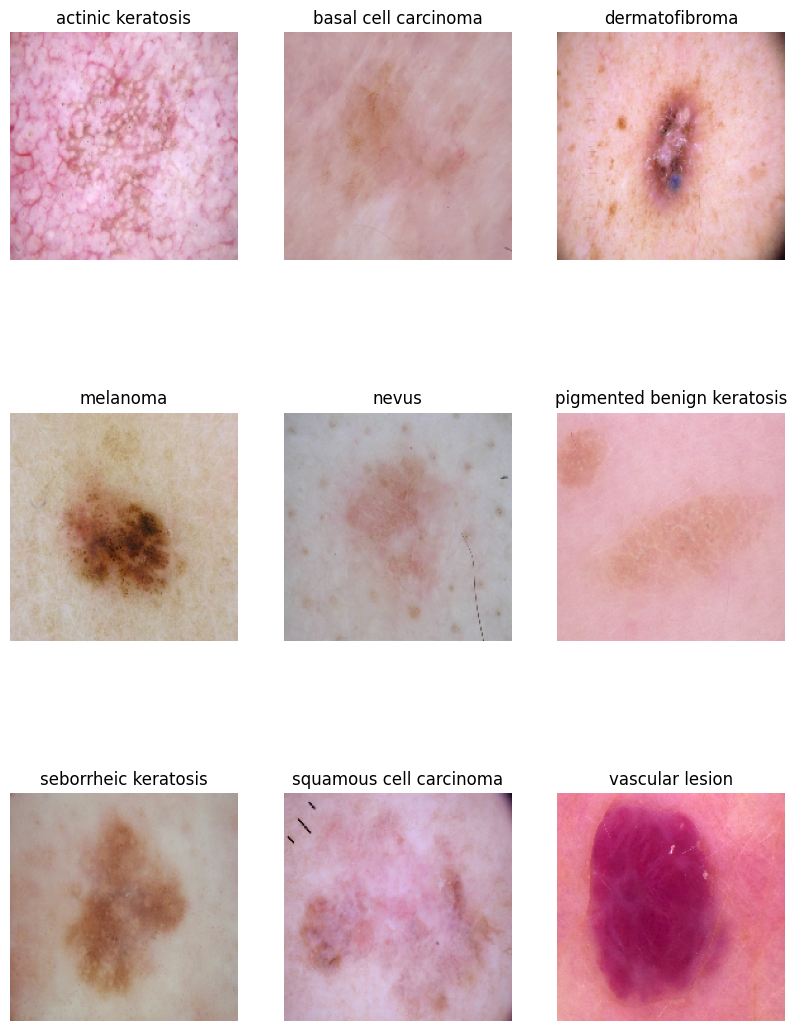

In [19]:
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

plt.figure(figsize=(10,14))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.